# Train Domain classifier on the [semantic scholar dataset](https://api.semanticscholar.org/corpus)

In [1]:
import json
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn import metrics, set_config
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from great_ai.utilities.clean import clean
from great_ai.utilities.parallel_map import parallel_map
from great_ai.utilities.language import is_english, predict_language
from great_ai import save_model, set_default_config, LargeFile

from preprocess import preprocess

## Configuration

In [2]:
PREFIX = "domain-"
DATASET_KEY = "data"
MAX_FILE_COUNT = 5
MODEL_KEY = "small-domain-prediction-v2"

In [3]:
set_default_config()
corpus_path = LargeFile(DATASET_KEY).get()

set_config(display="diagram")
plt.rcParams["figure.figsize"] = (30, 15)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.xmargin"] = 0

2022-04-10 09:40:33,153 |     INFO | Running in production mode ✅
2022-04-10 09:40:33,156 |  WARNING | The selected persistence driver (TinyDbDriver) is not threadsafe
2022-04-10 09:40:33,157 |     INFO | Defaults: configured ✅
2022-04-10 09:40:33,348 |     INFO | Fetching online versions of data
2022-04-10 09:40:33,743 |     INFO | Found versions: [0, 1]
2022-04-10 09:40:33,744 |     INFO | Lastest version of data-1 is 1
2022-04-10 09:40:33,745 |     INFO | File data-1 found in cache


## Preprocessing

In [4]:
def clean_file(p: Path) -> None:
    try:
        processed_path = p.with_name(f"{PREFIX}{p.stem}{p.suffix}")

        if processed_path.exists():
            return

        with open(p) as f:
            content = json.load(f)

        result = {
            preprocess(
                clean(f'{c["title"]} {c["abstract"]}', convert_to_ascii=True)
            ): c["domain"]
            for c in content
            if (
                c["domain"]
                and c["abstract"]
                and is_english(predict_language(c["abstract"]))
            )
        }

        with open(processed_path, "w") as f:
            json.dump(result, f)
    except Exception as e:
        print(f"Error ({e}) processing {p}")


parallel_map(
    clean_file,
    list(corpus_path.glob("s2-corpus-*.json"))[:MAX_FILE_COUNT],
    chunk_size=1,
)
None

  0%|          | 0/5 [00:00<?, ?it/s]INFO:great_ai.utilities.external.pylatexenc.latexwalker:Ignoring parse error (tolerant parsing mode): Unexpected mismatching closing brace: '}' @(1,7093)
INFO:great_ai.utilities.external.pylatexenc.latexwalker:Ignoring parse error (tolerant parsing mode): Unexpected mismatching closing brace: '}' @(1,811)
INFO:great_ai.utilities.external.pylatexenc.latexwalker:Ignoring parse error (tolerant parsing mode): Unexpected mismatching closing brace: '}' @(1,196)
INFO:great_ai.utilities.external.pylatexenc.latexwalker:Ignoring parse error (tolerant parsing mode): Unexpected mismatching closing brace: '}' @(1,561)
INFO:great_ai.utilities.external.pylatexenc.latexwalker:Ignoring parse error (tolerant parsing mode): Unexpected mismatching closing brace: '}' @(1,1370)
INFO:great_ai.utilities.external.pylatexenc.latexwalker:Ignoring parse error (tolerant parsing mode): Unexpected mismatching closing brace: '}' @(1,215)
INFO:great_ai.utilities.external.pylatexenc

In [5]:
corpora = list(corpus_path.glob(f"{PREFIX}*.json"))[:MAX_FILE_COUNT]
print(f"Found {len(corpora)} files")

data = []
for p in corpora:
    with open(p) as f:
        data.extend(json.load(f).items())

print(f"Found {len(data)} documents")

X_train, X_test, y_train, y_test = train_test_split(
    [d[0] for d in data], [d[1] for d in data], test_size=0.1, random_state=1
)

X_train = [x for x, y in zip(X_train, y_train) for domain in y]
y_train = [domain for x, y in zip(X_train, y_train) for domain in y]

Found 5 files
Found 76862 documents


## Naive Bayes

In [6]:
classifier = GridSearchCV(
    Pipeline(steps=[("vectorizer", TfidfVectorizer()), ("classifier", ComplementNB())]),
    {
        "vectorizer__max_df": [0.1, 0.3],
        "vectorizer__min_df": [5, 10, 30],
        "vectorizer__sublinear_tf": [True, False],
        "classifier__alpha": [0.1, 0.5, 1],
        "classifier__fit_prior": [True, False],
    },
    scoring="f1_macro",
    cv=3,
    n_jobs=4,
    verbose=1,
)
classifier.fit(X_train, y_train)

results = pd.DataFrame(classifier.cv_results_)
results.sort_values("rank_test_score")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__fit_prior,param_vectorizer__max_df,param_vectorizer__min_df,param_vectorizer__sublinear_tf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
37,353.990156,490.126502,3.731860,0.097140,0.5,False,0.1,5,False,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.495838,0.499754,0.501146,0.498912,0.002247,1
25,671.987925,469.392562,335.414978,468.916068,0.5,True,0.1,5,False,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.495838,0.499754,0.501146,0.498912,0.002247,1
1,334.102561,460.200041,4.549770,0.351197,0.1,True,0.1,5,False,"{'classifier__alpha': 0.1, 'classifier__fit_pr...",0.495637,0.499200,0.501269,0.498702,0.002326,3
13,6.975998,0.301279,3.720828,0.145939,0.1,False,0.1,5,False,"{'classifier__alpha': 0.1, 'classifier__fit_pr...",0.495637,0.499200,0.501269,0.498702,0.002326,3
7,8.587186,0.258101,3.718949,0.054138,0.1,True,0.3,5,False,"{'classifier__alpha': 0.1, 'classifier__fit_pr...",0.495246,0.498718,0.500819,0.498261,0.002298,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,7.424036,0.104495,3.518187,0.103824,0.5,True,0.3,30,True,"{'classifier__alpha': 0.5, 'classifier__fit_pr...",0.471803,0.470317,0.465951,0.469357,0.002484,67
22,7.288773,0.153564,3.557420,0.152864,0.1,False,0.3,30,True,"{'classifier__alpha': 0.1, 'classifier__fit_pr...",0.470711,0.469985,0.467028,0.469241,0.001593,69
10,627.484071,438.167044,3.580379,0.105862,0.1,True,0.3,30,True,"{'classifier__alpha': 0.1, 'classifier__fit_pr...",0.470711,0.469985,0.467028,0.469241,0.001593,69
58,341.006728,471.608243,3.780825,0.007465,1,True,0.3,30,True,"{'classifier__alpha': 1, 'classifier__fit_prio...",0.470638,0.469516,0.464513,0.468223,0.002663,71


In [7]:
classifier = Pipeline(
    steps=[
        ("vectorizer", TfidfVectorizer(min_df=10, max_df=0.1, token_pattern=r"[^ ]+")),
        ("classifier", ComplementNB(alpha=0.5, fit_prior=False)),
    ]
)

classifier.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.1, min_df=10, token_pattern='[^ ]+')),
                ('classifier', ComplementNB(alpha=0.5, fit_prior=False))])

                       precision    recall  f1-score   support

                  Art       0.44      0.44      0.44        80
              Biology       0.75      0.72      0.73       541
             Business       0.45      0.52      0.48       174
            Chemistry       0.77      0.71      0.74       728
     Computer Science       0.65      0.87      0.75       851
            Economics       0.65      0.56      0.60       171
          Engineering       0.60      0.36      0.45       473
Environmental Science       0.69      0.43      0.53       177
            Geography       0.51      0.23      0.32       165
              Geology       0.72      0.63      0.67       123
              History       0.41      0.19      0.26        73
    Materials Science       0.68      0.86      0.76       656
          Mathematics       0.77      0.59      0.67       307
             Medicine       0.88      0.92      0.90      2033
           Philosophy       0.64      0.12      0.21  

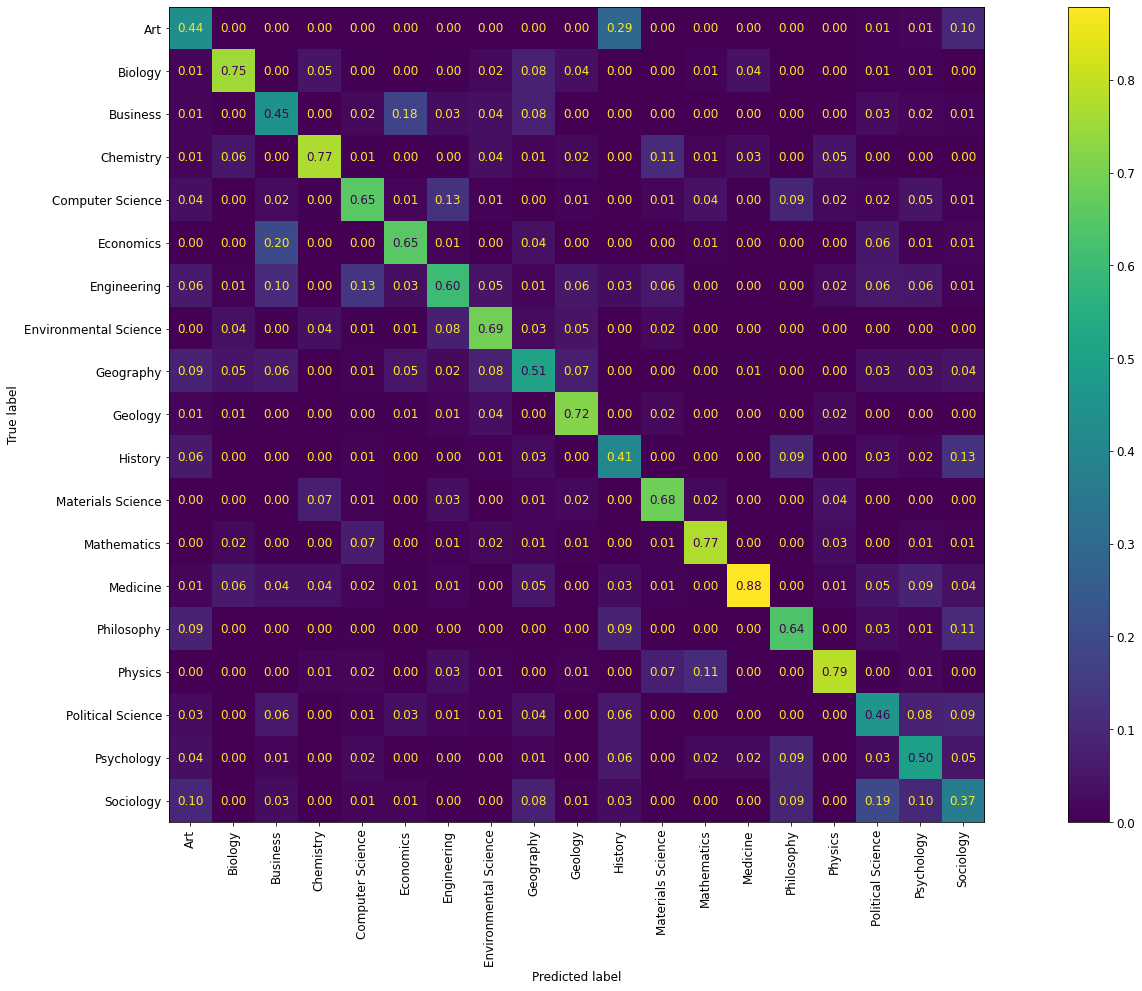

In [8]:
predicted = classifier.predict(X_test)

y_test_aligned = [p if p in y else y[0] for p, y in zip(predicted, y_test)]

print(metrics.classification_report(y_test_aligned, predicted))
metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=y_test_aligned,
    y_pred=predicted,
    xticks_rotation="vertical",
    normalize="pred",
    values_format=".2f",
)
None

In [9]:
save_model(classifier, key=MODEL_KEY, keep_last_n=1)

INFO:open_s3:Fetching online versions of small-domain-prediction-v2
INFO:open_s3:No versions found
INFO:open_s3:Copying file for small-domain-prediction-v2-0
INFO:open_s3:Compressing small-domain-prediction-v2-0
INFO:open_s3:Uploading small-domain-prediction-v2-0 to S3 from /var/folders/5g/yd_5_wg548q0yb4lnvg0y3q40000gn/T/large-file-pab4oxsr
INFO:open_s3:Uploading small-domain-prediction-v2-0.tar.gz 0.26/7.64 MB (3.4%)
INFO:open_s3:Uploading small-domain-prediction-v2-0.tar.gz 0.52/7.64 MB (6.9%)
INFO:open_s3:Uploading small-domain-prediction-v2-0.tar.gz 0.79/7.64 MB (10.3%)
INFO:open_s3:Uploading small-domain-prediction-v2-0.tar.gz 1.05/7.64 MB (13.7%)
INFO:open_s3:Uploading small-domain-prediction-v2-0.tar.gz 1.31/7.64 MB (17.2%)
INFO:open_s3:Uploading small-domain-prediction-v2-0.tar.gz 1.57/7.64 MB (20.6%)
INFO:open_s3:Uploading small-domain-prediction-v2-0.tar.gz 1.84/7.64 MB (24.0%)
INFO:open_s3:Uploading small-domain-prediction-v2-0.tar.gz 2.10/7.64 MB (27.5%)
INFO:open_s3:Uploa

0